In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import os
import torch
from pathlib import Path
import numpy as np
from jarvis.utils import tqdm

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

In [43]:
from hexarena.box import BaseFoodBox
from hexarena.monkey import Monkey

box = BaseFoodBox()
monkey = Monkey(num_grades=48, integrate_area=0.01)

In [95]:
xs, ys = [], []
n_samples = 50000
for _ in range(n_samples):
    cue = rng.uniform(0, 1)
    # cue = 1
    colors = box.get_colors(cue)
    obs = monkey.look(colors)
    xs.append(obs)
    ys.append(cue)
xs = np.array(xs)
ys = np.array(ys)

In [96]:
from irc.dist.space import DiscreteVarSpace, ContinuousVarSpace

x_space = DiscreteVarSpace(monkey.num_grades)
y_space = ContinuousVarSpace(low=0, high=1, resol=40)
y_space.update_anchors(torch.tensor(ys))

In [110]:
from irc.dist.net import BaseDistributionNet, create_net

net = create_net([x_space], [y_space])

In [114]:
stats = net.estimate(
    torch.tensor(xs, dtype=torch.float)[:, None], torch.tensor(ys, dtype=torch.float)[:, None],
    lr=0.01, num_epochs=40, z_reg=0.001,
)

  0%|                                                                                                         …

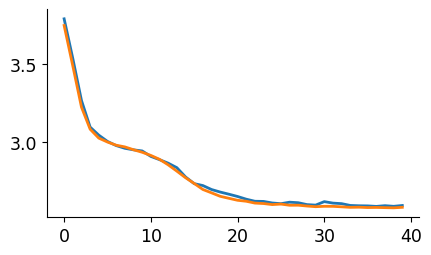

In [116]:
_, ax = plt.subplots()
ax.plot(stats['losses_train'][:, 0])
ax.plot(stats['losses_val'][:, 0])
plt.show()

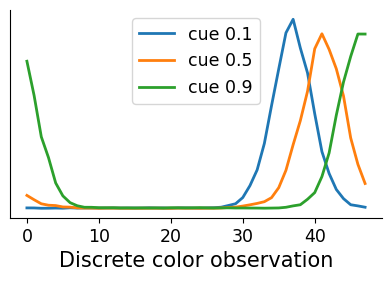

In [124]:
with torch.no_grad():
    *_, param_vecs = net(torch.tensor([0.1, 0.5, 0.9], dtype=torch.float)[:, None])

probs = torch.softmax(param_vecs, dim=1).numpy()

_, ax = plt.subplots()
ax.plot(np.arange(monkey.num_grades), probs.T)
ax.legend(['cue 0.1', 'cue 0.5', 'cue 0.9'], fontsize='small')
ax.set_xlabel('Discrete color observation')
ax.set_yticks([])
plt.show()